In [194]:
import xgboost as xgb
import math
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

import datetime as dt
import seaborn as sns

In [195]:
morning_dams = pd.read_csv('../datas/questionaire_data/ques_morning_dams.csv')

sleep = pd.read_csv('../datas/fitbit_preprocessed_data/sleep.csv')
calories = pd.read_csv('../datas/fitbit_preprocessed_data/calories.csv')
floors = pd.read_csv('../datas/fitbit_preprocessed_data/floors.csv')
heart = pd.read_csv('../datas/fitbit_preprocessed_data/heart.csv')
steps = pd.read_csv('../datas/fitbit_preprocessed_data/steps.csv')
minutesFairlyActive = pd.read_csv('../datas/fitbit_preprocessed_data/minutesFairlyActive.csv')
minutesLightlyActive = pd.read_csv('../datas/fitbit_preprocessed_data/minutesLightlyActive.csv')
minutesSedentary = pd.read_csv('../datas/fitbit_preprocessed_data/minutesSedentary.csv')
minutesVeryActive = pd.read_csv('../datas/fitbit_preprocessed_data/minutesVeryActive.csv')

weather = pd.read_csv('../datas/weather_data/weather_all.csv')

In [196]:
calories['Date'] = pd.to_datetime(calories['datetime']).dt.date
calories = calories[['Date','datetime','time','user_id','level','mets','calory']]
calories_day = calories.groupby(['user_id','Date'], as_index=False).mean()

floors['Date'] = pd.to_datetime(floors['datetime']).dt.date
floors = floors[['Date','datetime', 'time', 'user_id', 'floor']]
floors_day = floors.groupby(['user_id','Date'], as_index=False).mean()

steps['Date'] = pd.to_datetime(steps['datetime']).dt.date
steps = steps[['Date','datetime', 'time', 'user_id', 'step']]
steps_day = steps.groupby(['user_id','Date'], as_index=False).mean()

heart['Date'] = pd.to_datetime(heart['datetime']).dt.date
heart = heart[['Date','datetime', 'time', 'user_id', 'heart']]
heart_day = heart.groupby(['user_id','Date'], as_index=False).mean()

sleep['Date'] = pd.to_datetime(sleep['datetime']).dt.date
sleep = sleep[['Date','datetime', 'dateTime', 'user_id', 'sleep']]
sleep_day = sleep.groupby(['user_id','Date'], as_index=False).mean()

minutesFairlyActive['Date'] = pd.to_datetime(minutesFairlyActive['datetime']).dt.date
minutesFairlyActive = minutesFairlyActive[['Date','datetime', 'time', 'user_id', 'minutesFairlyActive']]
minutesFairlyActive_day = minutesFairlyActive.groupby(['user_id','Date'], as_index=False).mean()

minutesLightlyActive['Date'] = pd.to_datetime(minutesLightlyActive['datetime']).dt.date
minutesLightlyActive = minutesLightlyActive[['Date','datetime', 'time', 'user_id', 'minutesLightlyActive']]
minutesLightlyActive_day = minutesLightlyActive.groupby(['user_id','Date'], as_index=False).mean()

minutesSedentary['Date'] = pd.to_datetime(minutesSedentary['datetime']).dt.date
minutesSedentary = minutesSedentary[['Date','datetime', 'time', 'user_id', 'minutesSedentary']]
minutesSedentary_day = minutesSedentary.groupby(['user_id','Date'], as_index=False).mean()

minutesVeryActive['Date'] = pd.to_datetime(minutesVeryActive['datetime']).dt.date
minutesVeryActive = minutesVeryActive[['Date','datetime', 'time', 'user_id', 'minutesVeryActive']]
minutesVeryActive_day = minutesVeryActive.groupby(['user_id','Date'], as_index=False).mean()

In [197]:
fitbit_merge = pd.merge(calories_day, floors_day, on=['user_id','Date'])
fitbit_merge = pd.merge(fitbit_merge, heart_day,on=['user_id','Date'])
fitbit_merge = pd.merge(fitbit_merge, sleep_day,on=['user_id','Date'])
fitbit_merge = pd.merge(fitbit_merge, steps_day,on=['user_id','Date'])
fitbit_merge = pd.merge(fitbit_merge, minutesFairlyActive_day,on=['user_id','Date'])
fitbit_merge = pd.merge(fitbit_merge, minutesLightlyActive_day,on=['user_id','Date'])
fitbit_merge = pd.merge(fitbit_merge, minutesSedentary_day,on=['user_id','Date'])
fitbit_merge = pd.merge(fitbit_merge, minutesVeryActive_day,on=['user_id','Date'])
# fitbit_merge.to_csv('../datas/fitbit_merge_day.csv')

In [198]:
# morning_dams = morning_dams.drop('Unnamed: 0',axis=1)
# morning_dams = morning_dams.drop('Unnamed: 0.1',axis=1)
weather = weather.drop('Unnamed: 0',axis=1).drop('Unnamed: 0.1',axis=1)

In [199]:
morning_dams['posi_score'] = morning_dams['haturatu']+morning_dams['uresii']+morning_dams['tanosii']
morning_dams['nega_score'] = morning_dams['kurai']+morning_dams['iyana']+morning_dams['sizunda']
morning_dams['anx_score'] = morning_dams['sinpaina']+morning_dams['kigakarina']+morning_dams['fuan']
# sns.pairplot(morning_dams[['posi_score','nega_score','anx_score']],size=2.5)
# morning_dams[morning_dams['posi_score']<=6]
# morning_dams[(morning_dams['posi_score']>6)&(morning_dams['posi_score']<=12)]
# morning_dams[(morning_dams['posi_score']>12)]
morning_dams.loc[morning_dams['posi_score']<=6,'posi_class']=0
morning_dams.loc[(morning_dams['posi_score']>6)&(morning_dams['posi_score']<=12),'posi_class']=1
morning_dams.loc[morning_dams['posi_score']>12,'posi_class']=2

In [200]:
sns.pairplot(morning_dams[['posi_score','nega_score','anx_score','posi_class','locate']], hue="locate", size=2.5)

KeyError: "['locate'] not in index"

In [201]:
morning_dams.loc[morning_dams['user_id']<20,'locate']='osaka'
morning_dams.loc[morning_dams['user_id']>19,'locate']='tokyo'
morning_dams.loc[morning_dams['user_id']==100,'locate']='osaka'
morning_dams

,Unnamed: 0,Date,user_id,Unnamed: 0.1,record_type_id,value_dams,haturatu,uresii,tanosii,sinpaina,kigakarina,fuan,kurai,iyana,sizunda,posi_score,nega_score,anx_score,posi_class,locate
0,0,2021-01-07,13,17694,261.0,27.0,6.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,12.0,9.0,9.0,1.0,osaka
1,1,2021-01-07,17,6201,261.0,16.0,5.0,3.0,3.0,2.0,1.0,2.0,0.0,2.0,1.0,11.0,3.0,5.0,1.0,osaka
2,2,2021-01-07,33,106785,261.0,18.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,6.0,6.0,1.0,tokyo
3,3,2021-01-07,42,14589,261.0,26.0,6.0,2.0,2.0,4.0,4.0,4.0,1.0,3.0,2.0,10.0,6.0,12.0,1.0,tokyo
4,4,2021-01-11,7,13491,261.0,18.0,9.0,4.0,4.0,2.0,0.0,1.0,0.0,2.0,0.0,17.0,2.0,3.0,2.0,osaka
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,1192,2021-01-29,62,3029976,522.0,31.0,12.0,4.0,4.0,2.0,5.0,2.0,2.0,2.0,2.0,20.0,6.0,9.0,2.0,tokyo
1193,1193,2021-01-29,70,1482097,261.0,13.0,4.0,3.0,2.0,3.0,2.0,1.0,1.0,0.0,0.0,9.0,1.0,6.0,1.0,tokyo
1194,1194,2021-01-29,95,1477440,261.0,11.0,8.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,2.0,tokyo
1195,1195,2021-01-29,96,1482930,261.0,13.0,8.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,2.0,tokyo


In [229]:
dams_weather = pd.merge(morning_dams,weather,on=['Date','locate'])
dams_weather_fitbit = pd.merge(dams_weather,fitbit_merge_day,on=['Date','user_id'])

In [230]:
fitbit_merge_day = pd.read_csv('../datas/fitbit_merge_day.csv')
dams_fitbit = pd.merge(morning_dams,fitbit_merge,on=['Date','user_id'])

In [231]:
# dams_weather
fitbit_merge_day['Date'] = fitbit_merge_day['Date'].astype(str)
dams_weather['Date'] = dams_weather['Date'].astype(str)

In [232]:
fitbit_merge_day['Date']
# dams_weather['Date']
dams_weather_fitbit

,Unnamed: 0_x,Date,user_id,Unnamed: 0.1,record_type_id,value_dams,haturatu,uresii,tanosii,sinpaina,...,mets,calory,floor,heart,sleep,step,minutesFairlyActive,minutesLightlyActive,minutesSedentary,minutesVeryActive
0,12,2021-01-11,15,20817,261.0,19.0,1.0,0.0,0.0,4.0,...,15.325000,1.445148,0.011111,71.944291,1.050761,7.453472,0.025694,0.122917,0.835417,0.015972
1,14,2021-01-11,18,44811,261.0,18.0,8.0,4.0,4.0,1.0,...,16.015972,1.542018,0.011806,77.891945,1.034014,7.844444,0.018750,0.152083,0.817361,0.011806
2,15,2021-01-11,19,5346,261.0,19.0,5.0,3.0,3.0,2.0,...,15.675000,1.036118,0.006944,78.157494,1.046296,9.632639,0.006944,0.177083,0.805556,0.010417
3,16,2021-01-11,21,10008,261.0,11.0,8.0,3.0,3.0,0.0,...,12.402083,1.322806,0.000694,79.573406,1.025641,1.224306,0.000000,0.070833,0.929167,0.000000
4,21,2021-01-11,28,16677,261.0,28.0,4.0,3.0,1.0,4.0,...,15.500694,1.333370,0.000000,65.353201,1.033632,6.776389,0.000000,0.221528,0.778472,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,1186,2021-01-29,43,1528461,261.0,7.0,5.0,2.0,2.0,0.0,...,12.711111,1.018796,0.008333,71.939267,1.087500,4.631250,0.002083,0.032639,0.935417,0.029861
691,1187,2021-01-29,44,1480320,261.0,7.0,0.0,0.0,0.0,2.0,...,17.390278,1.883019,0.022917,85.168857,1.172113,6.065972,0.011111,0.079861,0.861111,0.047917
692,1188,2021-01-29,46,1548144,261.0,26.0,0.0,0.0,0.0,4.0,...,16.966667,1.836811,0.015278,72.019784,1.053512,7.737500,0.006944,0.112500,0.834722,0.045833
693,1191,2021-01-29,57,1314429,229.0,24.0,6.0,3.0,3.0,3.0,...,14.263194,1.448855,0.015972,74.232657,1.064073,5.213194,0.007639,0.095833,0.877778,0.018750


In [234]:
dams_fitbit = pd.merge(morning_dams,fitbit_merge_day,on=['Date','user_id'])
dams_fitbit

,Unnamed: 0_x,Date,user_id,Unnamed: 0.1,record_type_id,value_dams,haturatu,uresii,tanosii,sinpaina,...,mets,calory,floor,heart,sleep,step,minutesFairlyActive,minutesLightlyActive,minutesSedentary,minutesVeryActive
0,1,2021-01-07,17,6201,261.0,16.0,5.0,3.0,3.0,2.0,...,13.480556,1.609983,0.002778,59.091850,1.101124,2.543056,0.000000,0.142361,0.857639,0.000000
1,2,2021-01-07,33,106785,261.0,18.0,4.0,2.0,2.0,2.0,...,14.265972,1.469110,0.002778,70.685905,1.099237,3.640972,0.000000,0.156944,0.843056,0.000000
2,3,2021-01-07,42,14589,261.0,26.0,6.0,2.0,2.0,4.0,...,12.386111,0.892172,0.001389,66.182877,1.030986,2.097222,0.004861,0.079167,0.913889,0.002083
3,12,2021-01-11,15,20817,261.0,19.0,1.0,0.0,0.0,4.0,...,15.325000,1.445148,0.011111,71.944291,1.050761,7.453472,0.025694,0.122917,0.835417,0.015972
4,14,2021-01-11,18,44811,261.0,18.0,8.0,4.0,4.0,1.0,...,16.015972,1.542018,0.011806,77.891945,1.034014,7.844444,0.018750,0.152083,0.817361,0.011806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,1187,2021-01-29,44,1480320,261.0,7.0,0.0,0.0,0.0,2.0,...,17.390278,1.883019,0.022917,85.168857,1.172113,6.065972,0.011111,0.079861,0.861111,0.047917
694,1188,2021-01-29,46,1548144,261.0,26.0,0.0,0.0,0.0,4.0,...,16.966667,1.836811,0.015278,72.019784,1.053512,7.737500,0.006944,0.112500,0.834722,0.045833
695,1191,2021-01-29,57,1314429,229.0,24.0,6.0,3.0,3.0,3.0,...,14.263194,1.448855,0.015972,74.232657,1.064073,5.213194,0.007639,0.095833,0.877778,0.018750
696,1192,2021-01-29,62,3029976,522.0,31.0,12.0,4.0,4.0,2.0,...,14.136806,1.073408,0.000694,86.244023,1.024038,3.618056,0.000000,0.177083,0.822917,0.000000


In [235]:
dams_weather_fitbit.columns

Index(['Unnamed: 0_x', 'Date', 'user_id', 'Unnamed: 0.1', 'record_type_id',
       'value_dams', 'haturatu', 'uresii', 'tanosii', 'sinpaina', 'kigakarina',
       'fuan', 'kurai', 'iyana', 'sizunda', 'posi_score', 'nega_score',
       'anx_score', 'posi_class', 'locate', 'ave_temperature',
       'max_temperature', 'mini_temperature', 'sum_rainfall', 'ave_windspeed',
       'ave_vaporpressure', 'ave_humidity', 'ave_cloudcover', 'weather_6to18',
       'weather_18to6', 'Unnamed: 0_y', 'level', 'mets', 'calory', 'floor',
       'heart', 'sleep', 'step', 'minutesFairlyActive', 'minutesLightlyActive',
       'minutesSedentary', 'minutesVeryActive'],
      dtype='object')

In [259]:
dams_weather_fitbit['posi_class'].unique()
dams_weather_fitbit['posi_class'].value_counts()

1.0    266
2.0    224
0.0    205
Name: posi_class, dtype: int64

[0]	train-mlogloss:0.96650	eval-mlogloss:1.06969
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:0.87347	eval-mlogloss:1.05868
[2]	train-mlogloss:0.78955	eval-mlogloss:1.05157
[3]	train-mlogloss:0.72742	eval-mlogloss:1.05077
[4]	train-mlogloss:0.66158	eval-mlogloss:1.04714
[5]	train-mlogloss:0.61797	eval-mlogloss:1.05754
[6]	train-mlogloss:0.56795	eval-mlogloss:1.05245
[7]	train-mlogloss:0.51009	eval-mlogloss:1.05167
[8]	train-mlogloss:0.47677	eval-mlogloss:1.05857
[9]	train-mlogloss:0.43812	eval-mlogloss:1.06829
[10]	train-mlogloss:0.41580	eval-mlogloss:1.08027
[11]	train-mlogloss:0.38195	eval-mlogloss:1.08502
[12]	train-mlogloss:0.36447	eval-mlogloss:1.09339
[13]	train-mlogloss:0.34951	eval-mlogloss:1.10200
[14]	train-mlogloss:0.33497	eval-mlogloss:1.11551
Stopping. Best iteration:
[4]	train-mlogloss:0.66158	eval-mlogloss:1.04714

Accuracy: 0.42105263157894735


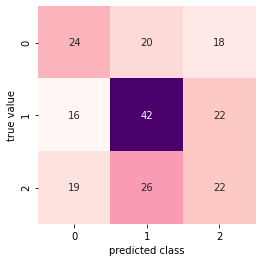

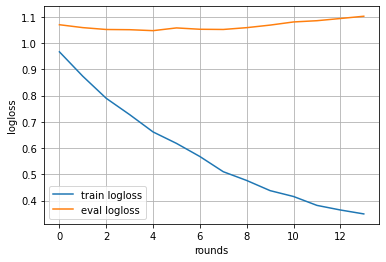

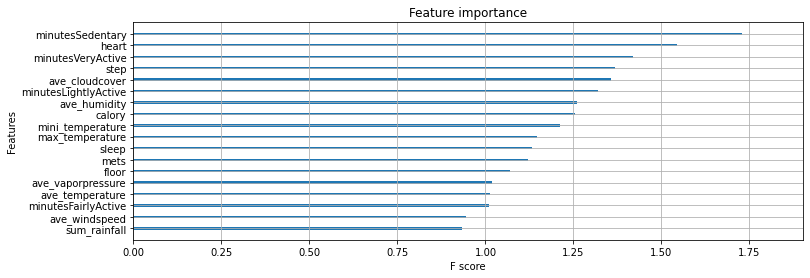

In [263]:
import xgboost as xgb

from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

"""XGBoost で多値分類するサンプルコード"""


def main():
    X = dams_weather_fitbit[[ 'ave_temperature','max_temperature', 'mini_temperature', 'sum_rainfall', 'ave_windspeed','ave_vaporpressure', 'ave_humidity', 'ave_cloudcover', 'mets', 'calory', 'floor','heart', 'sleep', 'step', 'minutesFairlyActive', 'minutesLightlyActive','minutesSedentary', 'minutesVeryActive']]

    y=dams_weather_fitbit['posi_class']
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        shuffle=True,
                                                        random_state=42,
                                                        stratify=y)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    xgb_params = {
        # 多値分類問題
        'objective': 'multi:softmax',
        # クラス数
        'num_class': 3,
        # 学習用の指標 (Multiclass logloss)
        'eval_metric': 'mlogloss',
    }
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    evals_result = {}
    bst = xgb.train(xgb_params,
                    dtrain,
                    num_boost_round=1000,
                    early_stopping_rounds=10,
                    evals=evals,
                    evals_result=evals_result,
                    )

    y_pred = bst.predict(dtest)
    acc = accuracy_score(y_test, y_pred)
    print('Accuracy:', acc)
    
    mat = confusion_matrix(y_test,y_pred)
    sns.heatmap(mat,square=True,annot=True,cbar=False,fmt='d',cmap='RdPu')
    plt.xlabel('predicted class')
    plt.ylabel('true value')
    plt.show()


    train_metric = evals_result['train']['mlogloss']
    plt.plot(train_metric, label='train logloss')
    eval_metric = evals_result['eval']['mlogloss']
    plt.plot(eval_metric, label='eval logloss')
    plt.grid()
    plt.legend()
    plt.xlabel('rounds')
    plt.ylabel('logloss')
    plt.show()
    
    _, ax = plt.subplots(figsize=(12, 4))
    xgb.plot_importance(bst,
                    ax=ax,
                    importance_type='gain',
                    show_values=False)
    plt.show()


if __name__ == '__main__':
    main()

[0]	train-mlogloss:0.97167	eval-mlogloss:1.07590
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:0.88846	eval-mlogloss:1.06934
[2]	train-mlogloss:0.80784	eval-mlogloss:1.06656
[3]	train-mlogloss:0.75316	eval-mlogloss:1.07666
[4]	train-mlogloss:0.71201	eval-mlogloss:1.07759
[5]	train-mlogloss:0.66534	eval-mlogloss:1.07270
[6]	train-mlogloss:0.61204	eval-mlogloss:1.07014
[7]	train-mlogloss:0.56759	eval-mlogloss:1.06955
[8]	train-mlogloss:0.51301	eval-mlogloss:1.06676
[9]	train-mlogloss:0.48736	eval-mlogloss:1.07215
[10]	train-mlogloss:0.46135	eval-mlogloss:1.07174
[11]	train-mlogloss:0.43892	eval-mlogloss:1.06713
[12]	train-mlogloss:0.42377	eval-mlogloss:1.07022
Stopping. Best iteration:
[2]	train-mlogloss:0.80784	eval-mlogloss:1.06656

Accuracy: 0.4784688995215311


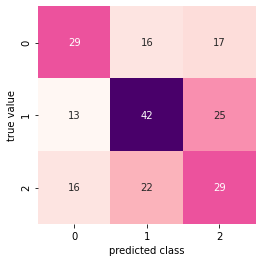

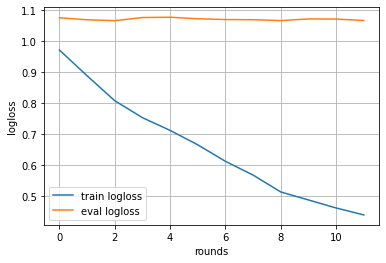

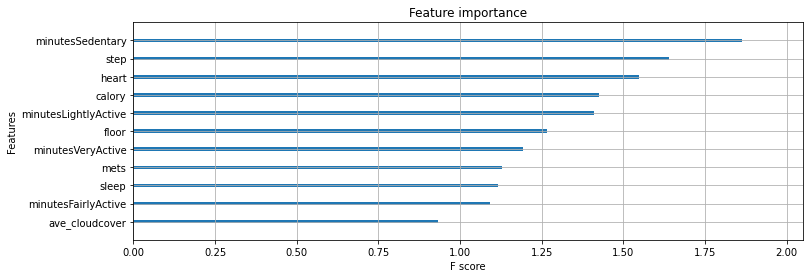

In [270]:
import xgboost as xgb

from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

"""XGBoost で多値分類するサンプルコード"""


def main():
    X = dams_weather_fitbit[[ 'ave_cloudcover', 'mets', 'calory', 'floor','heart', 'sleep', 'step', 'minutesFairlyActive', 'minutesLightlyActive','minutesSedentary', 'minutesVeryActive']]

    y=dams_weather_fitbit['posi_class']
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        shuffle=True,
                                                        random_state=42,
                                                        stratify=y)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    xgb_params = {
        # 多値分類問題
        'objective': 'multi:softmax',
        # クラス数
        'num_class': 3,
        # 学習用の指標 (Multiclass logloss)
        'eval_metric': 'mlogloss',
    }
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    evals_result = {}
    bst = xgb.train(xgb_params,
                    dtrain,
                    num_boost_round=1000,
                    early_stopping_rounds=10,
                    evals=evals,
                    evals_result=evals_result,
                    )

    y_pred = bst.predict(dtest)
    acc = accuracy_score(y_test, y_pred)
    print('Accuracy:', acc)
    
    mat = confusion_matrix(y_test,y_pred)
    sns.heatmap(mat,square=True,annot=True,cbar=False,fmt='d',cmap='RdPu')
    plt.xlabel('predicted class')
    plt.ylabel('true value')
    plt.show()


    train_metric = evals_result['train']['mlogloss']
    plt.plot(train_metric, label='train logloss')
    eval_metric = evals_result['eval']['mlogloss']
    plt.plot(eval_metric, label='eval logloss')
    plt.grid()
    plt.legend()
    plt.xlabel('rounds')
    plt.ylabel('logloss')
    plt.show()
    
    _, ax = plt.subplots(figsize=(12, 4))
    xgb.plot_importance(bst,
                    ax=ax,
                    importance_type='gain',
                    show_values=False)
    plt.show()


if __name__ == '__main__':
    main()

In [267]:
import lightgbm as lgb

import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

"""LightGBM を使った多値分類のサンプルコード"""


def main():
    X = dams_weather_fitbit[[ 'ave_temperature','max_temperature', 'mini_temperature', 'sum_rainfall', 'ave_windspeed','ave_vaporpressure', 'ave_humidity', 'ave_cloudcover', 'mets', 'calory', 'floor','heart', 'sleep', 'step', 'minutesFairlyActive', 'minutesLightlyActive','minutesSedentary', 'minutesVeryActive']]

    y=dams_weather_fitbit['posi_class']

    # データセットを学習用とテスト用に分割する
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    # テスト用のデータを評価用と検証用に分ける
    X_eval, X_valid, y_eval, y_valid = train_test_split(X_test, y_test, random_state=42)

    # データセットを生成する
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train)

    # LightGBM のハイパーパラメータ
    lgbm_params = {
        # 多値分類問題
        'objective': 'multiclass',
        # クラス数は 3
        'num_class': 3,
    }

    # 上記のパラメータでモデルを学習する
    model = lgb.train(lgbm_params, lgb_train,
                      # モデルの評価用データを渡す
                      valid_sets=lgb_eval,
                      # 最大で 1000 ラウンドまで学習する
                      num_boost_round=1000,
                      # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                      early_stopping_rounds=10)

    # 学習したモデルでホールドアウト検証する
    y_pred_proba = model.predict(X_valid, num_iteration=model.best_iteration)
    # 返り値は確率になっているので最尤に寄せる
    y_pred = np.argmax(y_pred_proba, axis=1)

    # 精度 (Accuracy) を計算する
    accuracy = accuracy_score(y_valid, y_pred)
    print('Accuracy:',accuracy)
    
    mat = confusion_matrix(y_test,y_pred)
    sns.heatmap(mat,square=True,annot=True,cbar=False,fmt='d',cmap='RdPu')
    plt.xlabel('predicted class')
    plt.ylabel('true value')
    plt.show()


if __name__ == '__main__':
    main()

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 521, number of used features: 18
[LightGBM] [Info] Start training from score -1.251804
[LightGBM] [Info] Start training from score -0.977635
[LightGBM] [Info] Start training from score -1.085266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 1.08531
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


ValueError: Found input variables with inconsistent numbers of samples: [174, 44]

In [272]:
weather.columns

Index(['Date', 'ave_temperature', 'max_temperature', 'mini_temperature',
       'sum_rainfall', 'ave_windspeed', 'ave_vaporpressure', 'ave_humidity',
       'ave_cloudcover', 'weather_6to18', 'weather_18to6', 'locate'],
      dtype='object')